
<table class="ee-notebook-buttons" align="left">
    <td><a target="_parent"  href="https://github.com/MVOSlab-sdstate/AST426_Lab/blob/main/Lab%2005/AST426L-Lab5-Part1-Landsat.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td>
    <td><a target="_parent"  href="https://nbviewer.org/github/MVOSlab-sdstate/AST426_Lab/blob/main/Lab%2005/AST426L-Lab5-Part1-Landsat.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td>
    <td><a target="_parent"  href="https://colab.research.google.com/github/MVOSlab-sdstate/AST426_Lab/blob/main/Lab%2005/AST426L-Lab5-Part1-Landsat.ipynb"><img width=26px src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
    </table>

In [ ]:
# Install necessary packages if not installed
!pip install geemap

# Import libraries
import geemap
import ee
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Authenticate and initialize Google Earth Engine API
ee.Authenticate()

# Change 'my-project' to your actual project
ee.Initialize(project='ee-mvoslabsdstate')

<p style = "font-size: X-large; font-family:'Georgia';"> Define Area of Interest (AOI) and Load Landsat Data. Also Vizualize the AOI by sliding the bar for WorldImagery to the left. </p>

In [ ]:
# Define your area of interest (AOI) - replace with specific coordinates of the farm in South Dakota
aoi = ee.Geometry.Rectangle([-96.677308, 44.303835, -96.667671, 44.296820])  # Example coordinates

# # Load the Landsat 8 Collection 2 image collection for the specified region and date range
# landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
#     .filterBounds(aoi) \
#     .filterDate('2023-05-01', '2023-09-30') \
#     .filter(ee.Filter.lt('CLOUD_COVER', 10))
# Display the first image in the collection
#landsat_image = landsat.first()

# Load Landsat 8 Collection 2 Surface Reflectance data
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filterBounds(aoi) \
            .filterDate('2024-5-1', '2024-09-23') \
            .filter(ee.Filter.lt('CLOUD_COVER', 10))  # Only consider images with less than 20% cloud cover

# Display the first image in the collection
landsat_image = landsat.first()

# Visualize the raw satellite image
Map = geemap.Map()
Map.centerObject(aoi, 50)

# Convert the AOI geometry to a feature collection for styling
aoi_feature = ee.FeatureCollection([ee.Feature(aoi)])

# Instead of styling as a dictionary, use the style parameters directly in Map.addLayer
Map.addLayer(aoi_feature.draw(color='blue', strokeWidth=5), {}, 'AOI Boundary')

# Visualization parameters for the Landsat image
landsat_vis_params = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # RGB bands
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Add the Landsat image to the map
Map.addLayer(landsat_image.clip(aoi), landsat_vis_params, "Landsat Image")
Map.add_basemap('HYBRID')  # Add basemap (e.g., satellite imagery)
Map


Map(center=[44.30032753145428, -96.67248950000993], controls=(WidgetControl(options=['position', 'transparent_…

<p style = "font-size: X-large; font-family:'Georgia';"> Generate and Visualize NDVI Map </p>

In [ ]:
# Function to calculate NDVI and NDRE for nitrogen estimation
def calculate_indices(image):
    # Convert digital numbers (DN) to reflectance for Landsat 8 Collection 2
    sr_image = image.multiply(0.0000275).add(-0.2)

    # NDVI calculation (NIR - Red) / (NIR + Red)
    ndvi = sr_image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

    # NDRE calculation (NIR - RedEdge) / (NIR + RedEdge)
    ndre = sr_image.normalizedDifference(['SR_B5', 'SR_B6']).rename('NDRE')

    return image.addBands([ndvi, ndre])

# Apply NDVI function to the image collection
landsat_ndvi = landsat.map(calculate_indices).select('NDVI')
landsat_ndre = landsat.map(calculate_indices).select('NDRE')

# Select the first image with NDVI for visualization
ndvi_image = landsat_ndvi.first()
ndre_image = landsat_ndre.first()

# Visualization parameters for the NDVI
ndvi_params = {
    'min': -0.2,
    'max': 0.9,
    'palette': ['red', 'yellow', 'green']
}

# Visualize NDVI map on the basemap
Map = geemap.Map()
Map.centerObject(aoi, 10)
# Convert the AOI geometry to a feature collection for styling
aoi_feature = ee.FeatureCollection([ee.Feature(aoi)])

# Instead of styling as a dictionary, use the style parameters directly in Map.addLayer
Map.addLayer(aoi_feature.draw(color='blue', strokeWidth=5), {}, 'AOI Boundary')

# Add NDVI layer to the map
Map.addLayer(ndvi_image.clip(aoi), ndvi_params, "NDVI Map")
Map.add_basemap('HYBRID')
Map

Map(center=[44.30032753145428, -96.67248950000993], controls=(WidgetControl(options=['position', 'transparent_…

<p style = "font-size: X-large; font-family:'Georgia';"> Estimate Nitrogen Content from NDVI Map </p>

In [ ]:
# Estimate Nitrogen content based on NDVI (Simple empirical relation: Nitrogen = NDVI * constant factor)
def estimate_nitrogen(image):
    ndvi = image.select('NDVI')
    nitrogen = ndvi.multiply(34.9).add(-1.52).multiply(10).rename('Nitrogen')  # Example formula of Nitrogen for Soybean based on a paper by:Fritschi, F. B., et al. (2003). Correlation of remote sensing based vegetation indices with soybean yield and leaf nitrogen concentration. Journal of Plant Nutrition, 26(2), 389-404.
    return image.addBands(nitrogen)

# Apply nitrogen estimation function to the NDVI images
landsat_nitrogen = landsat_ndvi.map(estimate_nitrogen)

# Select the nitrogen band from the most recent image for visualization
nitrogen_image = landsat_nitrogen.first().select('Nitrogen')

# Visualization parameters for the nitrogen map
nitrogen_params = {
    'min': 0,
    'max': 400,  # Adjust as needed
    'palette': ['yellow', 'green', 'darkgreen']
}

# Visualize Nitrogen map on the basemap
Map = geemap.Map()
Map.centerObject(aoi, 10)

# Convert the AOI geometry to a feature collection for styling
aoi_feature = ee.FeatureCollection([ee.Feature(aoi)])

# Instead of styling as a dictionary, use the style parameters directly in Map.addLayer
Map.addLayer(aoi_feature.draw(color='blue', strokeWidth=5), {}, 'AOI Boundary')

# Add Nitrogen layer to the map
Map.addLayer(nitrogen_image.clip(aoi), nitrogen_params, "Nitrogen Estimation")
Map.add_basemap('HYBRID')
Map


Map(center=[44.30032753145428, -96.67248950000993], controls=(WidgetControl(options=['position', 'transparent_…

<p style = "font-size: X-large; font-family:'Georgia';"> Create Time-Series Mean NDVI Values. </p>

In [ ]:
# Function to extract mean NDVI for the AOI
def get_ndvi_time_series(image_collection, start_date, end_date, region):
    """Extracts time-series data for NDVI over the AOI."""
    def aggregate_data(image):
        stat = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=30,  # Scale based on the spatial resolution of Landsat
            maxPixels=1e8,  # Handle large AOI
            bestEffort=True  # Use best effort to avoid pixel limits
        )
        return ee.Feature(None, {'date': image.date().format(), 'mean_ndvi': stat.get('NDVI')})

    image_collection = image_collection.filterDate(start_date, end_date)
    ndvi_time_series = image_collection.map(aggregate_data)
    return ndvi_time_series

# Get the NDVI time-series data for the AOI from previous NDVI calculation
ndvi_time_series = get_ndvi_time_series(landsat_ndvi, '2024-05-01', '2024-09-23', aoi) ##Match this with third codel cell line 15

# Convert the NDVI time-series data to a pandas DataFrame
time_series_list = ndvi_time_series.getInfo()['features']
dates = [pd.to_datetime(feature['properties']['date']) for feature in time_series_list]
mean_ndvi_values = [feature['properties']['mean_ndvi'] for feature in time_series_list]

# Create a DataFrame to hold dates and NDVI values
import pandas as pd
ndvi_df = pd.DataFrame({
    'date': dates,
    'mean_ndvi': mean_ndvi_values
})

# Display the extracted NDVI time-series for inspection
print(ndvi_df.head())

                 date  mean_ndvi
0 2024-07-10 17:10:46   0.811627
1 2024-07-26 17:11:00   0.890753
2 2024-09-12 17:11:16   0.703070


<p style = "font-size: X-large; font-family:'Georgia';"> Now using the previously published papers, we will apply equations to convert the NDVI values into Nitrogen content for four different crops : corn, soybean, alfalfa and wheat.
<ol style = "font-family: 'Georgia'; font-size: large;">
<li> Scharf, P. C., et al. (2006). Field-scale variability in optimal nitrogen fertilizer rate for corn. Agronomy Journal, 98(3), 397-404.</li>
<li> Fritschi, F. B., et al. (2003). Correlation of remote sensing based vegetation indices with soybean yield and leaf nitrogen concentration. Journal of Plant Nutrition, 26(2), 389-404. </li>
<li> Noland, R. L., et al. (2018). Estimating alfalfa yield and nutritive value using remote sensing and weather data. Agronomy Journal, 110(6), 2345-2354. </li>
<li> Raun, W. R., et al. (2001). In-season prediction of potential grain yield in winter wheat using canopy reflectance. Agronomy Journal, 93(1), 131-138. </li>
</ol>
</p>

In [ ]:
# Apply crop-specific nitrogen estimation equations based on the extracted NDVI values

# Corn: N rate (kg/ha) = 280 - 210 * NDVI
ndvi_df['corn_nitrogen'] = 280 - 210 * ndvi_df['mean_ndvi']

# Soybean: Total N (g/m²) = -1.52 + 34.9 * NDVI
ndvi_df['soybean_nitrogen'] = -1.52 + 34.9 * ndvi_df['mean_ndvi']

# Alfalfa: Forage N concentration (g/kg) = 12.8 + 25.6 * NDVI
ndvi_df['alfalfa_nitrogen'] = 12.8 + 25.6 * ndvi_df['mean_ndvi']

# Wheat: Grain N uptake (kg/ha) = 0.115 * e^(6.6673 * NDVI)
ndvi_df['wheat_nitrogen'] = 0.115 * np.exp(6.6673 * ndvi_df['mean_ndvi'])

# Display the DataFrame with nitrogen estimates for inspection
print(ndvi_df.head())

                 date  mean_ndvi  corn_nitrogen  soybean_nitrogen  \
0 2024-07-10 17:10:46   0.811627     109.558347         26.805780   
1 2024-07-26 17:11:00   0.890753      92.941956         29.567265   
2 2024-09-12 17:11:16   0.703070     132.355311         23.017141   

   alfalfa_nitrogen  wheat_nitrogen  
0         33.577649       25.752637  
1         35.603266       43.645125  
2         30.798591       12.487837  


<p style = "font-size: X-large; font-family:'Georgia';"> Use the Mean NDVI values to estimate Nitrogen content depending on the type of crops and previously published equations. </p>

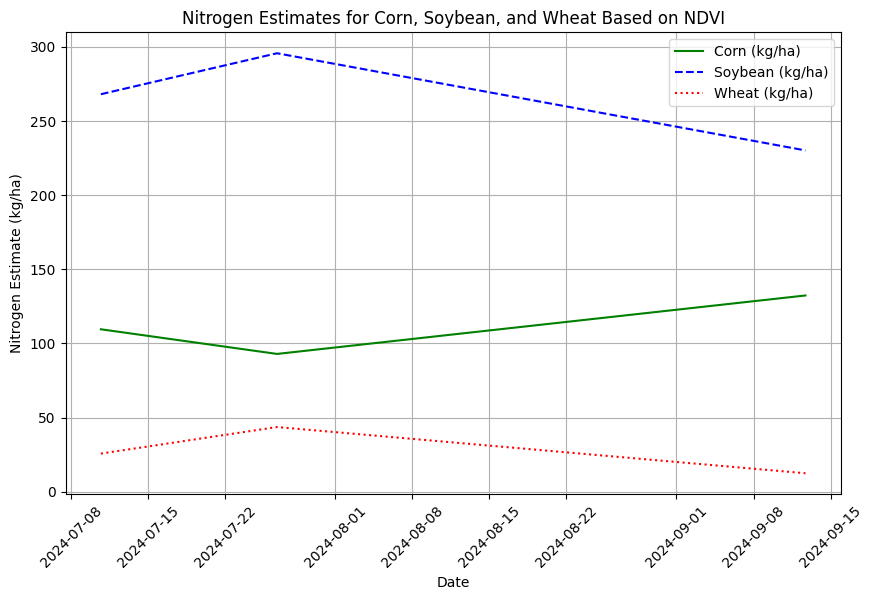

In [ ]:
# Apply unit conversion for Soybean from g/m² to kg/ha (1 g/m² = 10 kg/ha)
ndvi_df['soybean_nitrogen'] = ndvi_df['soybean_nitrogen'] * 10  # Convert from g/m² to kg/ha

# Now plot nitrogen estimates for all crops in kg/ha (excluding alfalfa for now since it's not in kg/ha)
plt.figure(figsize=(10, 6))

# Plot each crop's nitrogen estimates
plt.plot(ndvi_df['date'], ndvi_df['corn_nitrogen'], label='Corn (kg/ha)', color='green', linestyle='-')
plt.plot(ndvi_df['date'], ndvi_df['soybean_nitrogen'], label='Soybean (kg/ha)', color='blue', linestyle='--')  # Updated units
plt.plot(ndvi_df['date'], ndvi_df['wheat_nitrogen'], label='Wheat (kg/ha)', color='red', linestyle=':')  # Wheat in kg/ha

# Add titles and labels
plt.title('Nitrogen Estimates for Corn, Soybean, and Wheat Based on NDVI')
plt.xlabel('Date')
plt.ylabel('Nitrogen Estimate (kg/ha)')
plt.grid(True)
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.show()



<p style = "font-size: X-large; font-family:'Georgia';"> Use the USDA CroplandCROS Database to verify what crop was growing in the given time period and modify the plot showing only for that crop. </p>


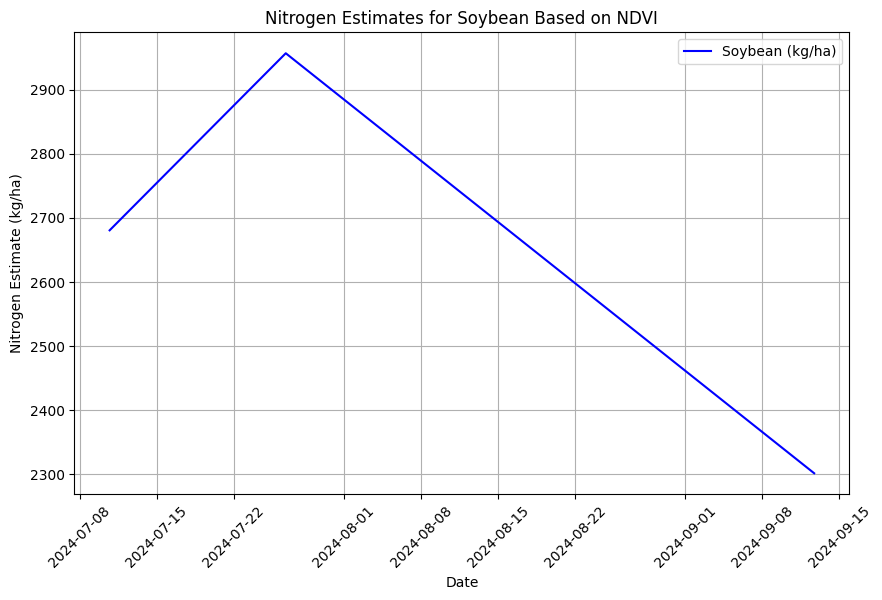

In [ ]:
# Plot nitrogen estimates for corn, soybean, alfalfa, and wheat on the same chart
# Apply unit conversion for Soybean from g/m² to kg/ha (1 g/m² = 10 kg/ha)
ndvi_df['soybean_nitrogen'] = ndvi_df['soybean_nitrogen'] * 10  # Convert from g/m² to kg/ha

plt.figure(figsize=(10, 6))

# Plot each crop's nitrogen estimates
plt.plot(ndvi_df['date'], ndvi_df['soybean_nitrogen'], label='Soybean (kg/ha)', color='blue', linestyle='-')  # Updated units

# Add titles and labels
plt.title('Nitrogen Estimates for Soybean Based on NDVI')
plt.xlabel('Date')
plt.ylabel('Nitrogen Estimate (kg/ha)')
plt.grid(True)
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.show()